<a href="https://www.kaggle.com/code/vidhikishorwaghela/llm-detect-ai-generated-text?scriptVersionId=187822363" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import csv

# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
files = ["test.csv", "test1.csv", "test2.csv"]
dfs = [pd.read_csv(file, sep='	') for file in files]
df = pd.concat(dfs, ignore_index=True)  # Replace with your actual file path


In [3]:
# Extract sentiment label if available and convert to numeric
if 'sentiment label' in df.columns:
    df['sentiment_label_clean'] = df['sentiment label'].astype(str).str.extract(r'(Positive|Negative|Neutral)', expand=False)
    df['sentiment_score_label'] = df['sentiment_label_clean'].map({'Positive': 1, 'Neutral': 0, 'Negative': -1}).fillna(0)
else:
    df['sentiment_score_label'] = 0


In [4]:
# Combine prompt with responses
df['human_text'] = df['prompt'] + " " + df['human']
df['ai_text'] = df['prompt'] + " " + df['ai']

In [5]:
human_df = pd.DataFrame({'text': df['human'], 'generated': 0})
ai_df = pd.DataFrame({'text': df['ai'], 'generated': 1})
train_essays = pd.concat([human_df, ai_df], ignore_index=True)

In [6]:
train_essays.head(300)

,text,generated
0,The code itself was patterned so that most con...,0
1,San Diego and its backcountry are subject to p...,0
2,I Love New York (stylized I ❤ NY) is both a lo...,0
3,Amensalism is an interaction where an organism...,0
4,"By the census of 1971, the population of Lanca...",0
...,...,...
295,They and other things like them - magnetic bra...,0
296,Most of them are going to hit the sides of you...,0
297,Its a metabolic waste product of the colonized...,0
298,"Gelatin in water is a mixture, not a solution,...",0


In [7]:
# Explore the training data
train_essays.info()
train_essays.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1200 non-null   object
 1   generated  1200 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.9+ KB


,text,generated
0,The code itself was patterned so that most con...,0
1,San Diego and its backcountry are subject to p...,0
2,I Love New York (stylized I ❤ NY) is both a lo...,0
3,Amensalism is an interaction where an organism...,0
4,"By the census of 1971, the population of Lanca...",0


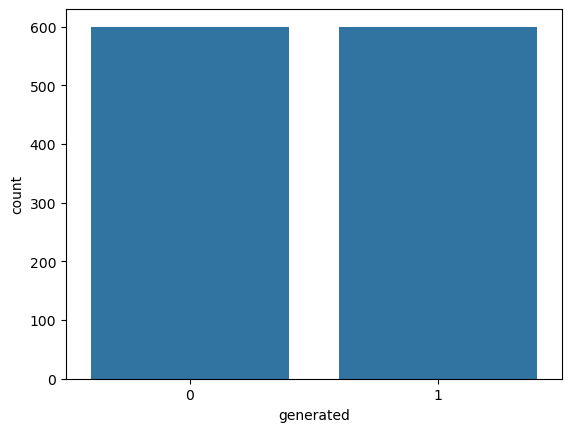

In [8]:
# Check for class balance
sns.countplot(data=train_essays, x='generated')
plt.show()


In [9]:
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', str(text))
    words = text.split()
    words = [word.lower() for word in words if word.isalpha()]
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

train_essays['clean_text'] = train_essays['text'].apply(clean_text)


In [10]:
# Apply VADER sentiment analysis
analyzer = SentimentIntensityAnalyzer()
def get_sentiment_score(text):
    return analyzer.polarity_scores(text)['compound']

def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [11]:
train_essays['vader_score'] = train_essays['clean_text'].apply(get_sentiment_score)
train_essays['vader_sentiment'] = train_essays['vader_score'].apply(classify_sentiment)


In [12]:
# Convert sentiment to binary labels
vader_binary = train_essays['vader_sentiment'].map({'positive': 0, 'neutral': 0, 'negative': 1})
y_true = train_essays['generated']
y_pred = vader_binary

In [13]:
# Evaluate VADER sentiment classification
print("\n--- VADER Sentiment Classification ---")
print("Accuracy (VADER):", accuracy_score(y_true, y_pred))
print("F1 Score (VADER):", f1_score(y_true, y_pred))
print("Classification Report (VADER):")
print(classification_report(y_true, y_pred, target_names=['Human', 'AI']))



--- VADER Sentiment Classification ---
Accuracy (VADER): 0.5016666666666667
F1 Score (VADER): 0.35
Classification Report (VADER):
              precision    recall  f1-score   support

       Human       0.50      0.73      0.60       600
          AI       0.50      0.27      0.35       600

    accuracy                           0.50      1200
   macro avg       0.50      0.50      0.47      1200
weighted avg       0.50      0.50      0.47      1200



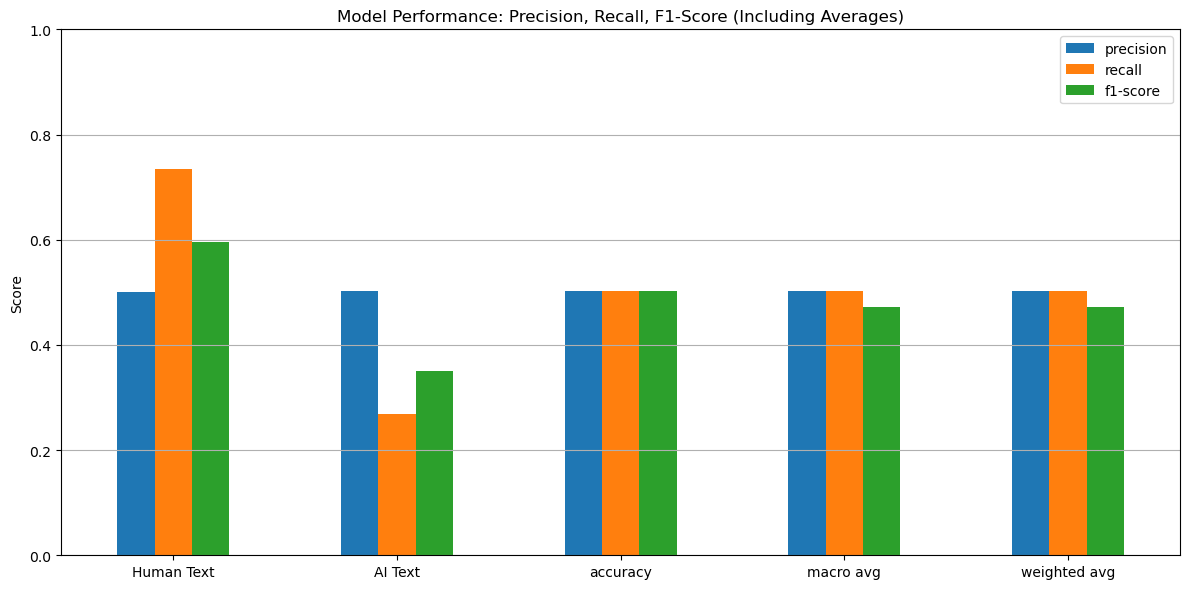

In [21]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Generate the classification report
report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# ✅ Rename index labels for clarity
label_map = {'0': 'Human Text', '1': 'AI Text'}
df_report.rename(index=label_map, inplace=True)

# ✅ Plot class-wise and average metrics (includes Human, AI, and avg rows)
df_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6))
plt.title("Model Performance: Precision, Recall, F1-Score (Including Averages)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
